In [35]:
!uv pip install grpcio grpcio-tools pandas matplotlib

Resolved 19 packages in 1.90s                                        
Prepared 4 packages in 1.58s                                             
Installed 8 packages in 39ms                                
 + contourpy==1.3.3
 + cycler==0.12.1
 + fonttools==4.61.0
 + kiwisolver==1.4.9
 + matplotlib==3.10.7
 + packaging==25.0
 + pillow==12.0.0
 + pyparsing==3.2.5


Generate Python code from the proto file

In [8]:
!uv run python -m grpc_tools.protoc -I../proto --python_out=. --grpc_python_out=. ../proto/topictrend.proto


In [19]:
import grpc
from grpc import StatusCode
import logging
import topictrend_pb2
import topictrend_pb2_grpc
from datetime import datetime, timedelta

channel_options = [
    ('grpc.keepalive_time_ms', 30000),
    ('grpc.keepalive_timeout_ms', 5000),
    ('grpc.keepalive_permit_without_calls', True),
    ('grpc.http2.max_pings_without_data', 0),
    ('grpc.http2.min_time_between_pings_ms', 10000),
]

class TopicTrendClient:
    def __init__(self, host='localhost', port=50051):
        self.channel = grpc.insecure_channel(f'{host}:{port}', options=channel_options)
        self.stub = topictrend_pb2_grpc.TopicTrendServiceStub(self.channel)
        self.logger = logging.getLogger(__name__)
    def close(self):
        self.channel.close()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.close()
        
    def _handle_grpc_error(self, e: grpc.RpcError):
        """Handle common gRPC errors"""
        error_mapping = {
            StatusCode.NOT_FOUND: "Resource not found",
            StatusCode.INVALID_ARGUMENT: "Invalid request parameters",
            StatusCode.INTERNAL: "Internal server error",
            StatusCode.UNAVAILABLE: "Service unavailable",
            StatusCode.DEADLINE_EXCEEDED: "Request timeout",
        }

        error_msg = error_mapping.get(e.code(), f"Unknown error: {e.details()}")
        self.logger.error(f"gRPC Error [{e.code()}]: {error_msg}")
        raise Exception(f"gRPC Error: {error_msg}")


In [48]:
client = TopicTrendClient()

In [62]:
def get_title_by_qid(qid, wiki="enwiki"):
    request = topictrend_pb2.TitleByQidRequest(wiki=wiki,qid=qid)
    try:
        response = client.stub.GetTitleByQid(request) 
        return response.title
    except grpc.RpcError as e:
        client._handle_grpc_error(e)
get_title_by_qid(42)

'Douglas_Adams'

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_page_views(views, label):
    """
    Args:
    views: array of objects with date, views keys. date is x axis, views is y axis
    """

    # 1. Extract data into a list of dictionaries
    data = []
    for view in response.views:
        data.append({
            'Date': view.date,
            'Views': view.views
        })

    # 2. Create a Pandas DataFrame
    df = pd.DataFrame(data)

    # 3. Convert the 'Date' column to datetime objects
    df['Date'] = pd.to_datetime(df['Date'])

    # 4. Set the 'Date' column as the index for time-series plotting
    df.set_index('Date', inplace=True)

    # 5. Create the plot
    plt.figure(figsize=(12, 6))
    df['Views'].plot(
        kind='line',
        marker='o',
        markersize=4,
        linestyle='-',
        color='#3498db', # A blue color
        linewidth=2
    )

    # 6. Add labels and a title
    plt.title(f'Daily Views for : {label}', fontsize=16, pad=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Daily Views', fontsize=12)

    # 7. Improve readability of the X-axis and add grid
    plt.xticks(rotation=45)
    plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation on y-axis
    plt.grid(axis='y', linestyle=':', alpha=0.6)
    plt.tight_layout()

    # 8. Display the plot
    plt.show()


    return df # Optionally return the DataFrame for further analysis

Find category views for a given time interval

Retrieved 30 daily view records
Date: 2025-11-01, Views: 798180
Date: 2025-11-02, Views: 854192
Date: 2025-11-03, Views: 981547
Date: 2025-11-04, Views: 986264
Date: 2025-11-05, Views: 972172


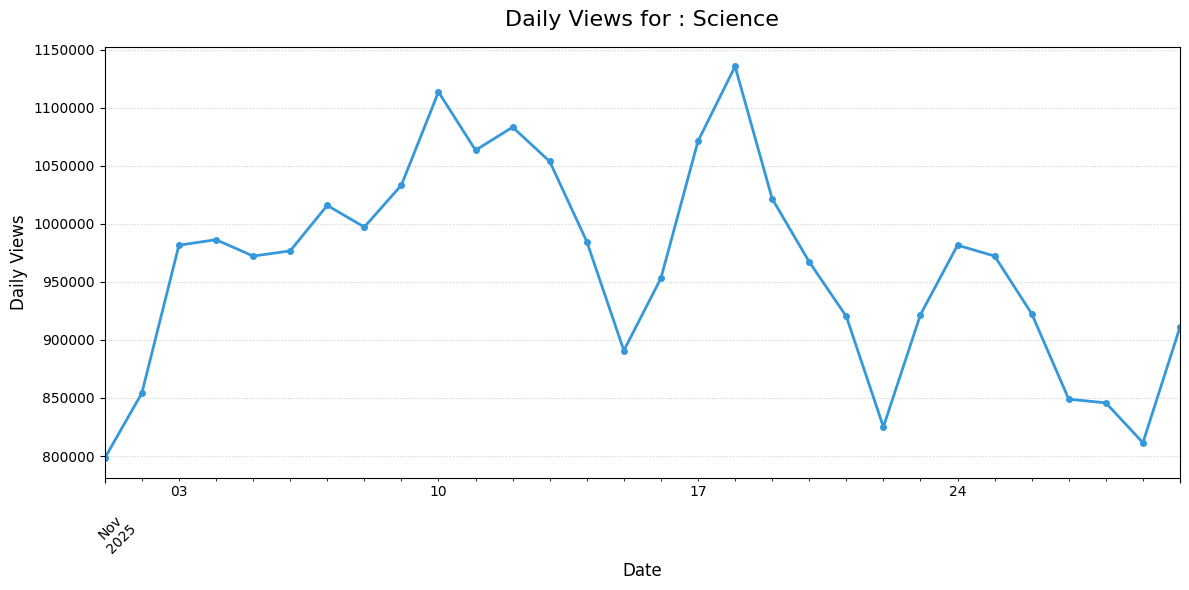

In [63]:
category_qid= 1458083
request = topictrend_pb2.CategoryViewsRequest(
        wiki="enwiki",
        category_qid=category_qid,
        start_date="2025-11-01",
        end_date="2025-11-30",
        depth=2
)

try:
    response = client.stub.GetCategoryViews(request)
    print(f"Retrieved {len(response.views)} daily view records")
    for view in response.views[:5]:  # Show first 5 records
        print(f"Date: {view.date}, Views: {view.views}")
    plot_page_views(response.views, get_title_by_qid(category_qid))
except grpc.RpcError as e:
    client._handle_grpc_error(e)


Retrieved 153 daily view records
Date: 2025-08-01, Views: 17087
Date: 2025-08-02, Views: 14868
Date: 2025-08-03, Views: 15303
Date: 2025-08-04, Views: 16467
Date: 2025-08-05, Views: 18940


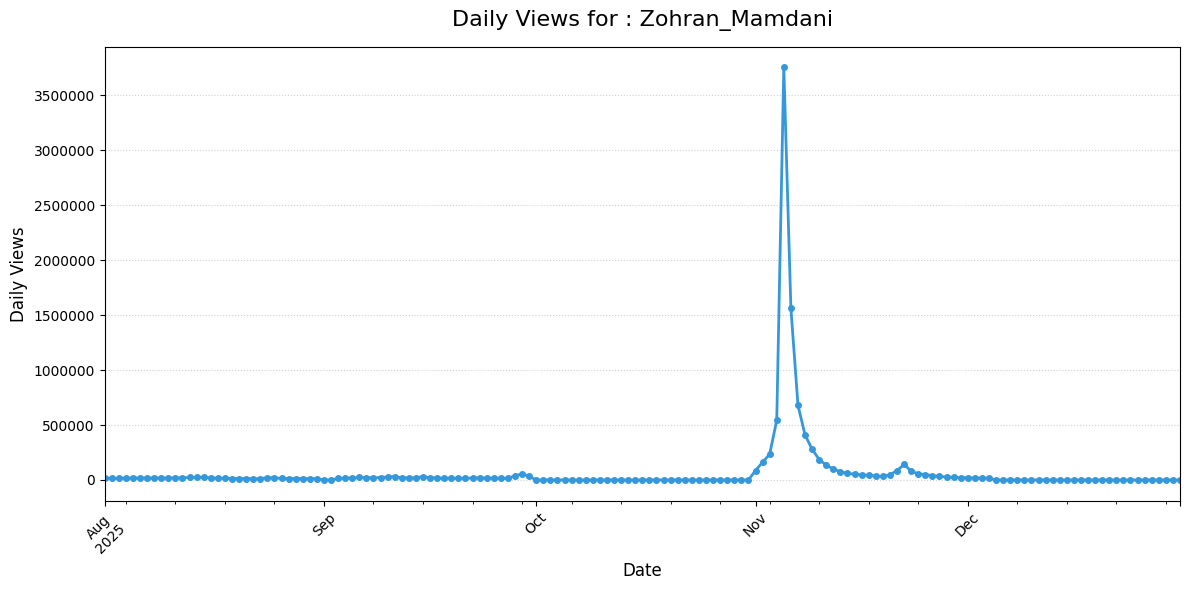

In [64]:
"""Get raw article pageviews data"""
article_qid=28034971
request = topictrend_pb2.ArticleViewsRequest(
    wiki="enwiki",
    article_qid=article_qid,
    start_date="2025-08-01",
    end_date="2025-12-31"
)

try:
    response = client.stub.GetArticleViews(request)
    print(f"Retrieved {len(response.views)} daily view records")
    for view in response.views[:5]:  # Show first 5 records
        print(f"Date: {view.date}, Views: {view.views}")
    plot_page_views(response.views, get_title_by_qid(article_qid))
except grpc.RpcError as e:
    client._handle_grpc_error(e)


In [65]:

"""Convert QIDs to titles"""
 
request = topictrend_pb2.TitlesByQidsRequest(
    wiki="enwiki",
    qids=[42, 1, 2]
)

try:
    response = client.stub.GetTitlesByQids(request)
    print("QID to Title mapping:")
    for qid, title in response.titles.items():
        print(f"Q{qid}: {title}")
except grpc.RpcError as e:
    client._handle_grpc_error(e)



QID to Title mapping:
Q1: Universe
Q2: Earth
Q42: Douglas_Adams


In [ ]:
# Get child categories of a category

In [77]:

with TopicTrendClient() as client:
    request = topictrend_pb2.ChildCategoriesRequest(
        wiki="enwiki",
        category_qid=558331
    )
    
    try:
        response = client.stub.GetChildCategories(request)
        print(f"Found {len(response.category_qids)} child categories:")
        for qid in response.category_qids[:10]:  # Show first 10
            title = get_title_by_qid(qid)
            print(f"Q{qid} - {title}")
    except grpc.RpcError as e:
        client._handle_grpc_error(e)



Found 36 child categories:
Q136486629 - Artificial_intelligence_by_country
Q136672912 - 15.ai
Q25250433 - Affective_computing
Q8242800 - Ambient_intelligence
Q8000750 - Applications_of_artificial_intelligence
Q60979166 - Argument_technology
Q110834987 - Artificial_intelligence_art
Q136484165 - Artificial_intelligence_controversies
Q52701496 - Automated_reasoning
Q105571721 - Artificial_intelligence_competitions


# Get top categories with raw data

In [75]:
 
with TopicTrendClient() as client:
    request = topictrend_pb2.TopCategoriesRawRequest(
        wiki="enwiki",
        start_date="2025-10-01",
        end_date="2025-12-31",
        limit=10
    )
    
    try:
        response = client.stub.GetTopCategoriesRaw(request)
        print(f"Top {len(response.categories)} categories:")
        for cat in response.categories:
            print(f"Category Q{cat.category_qid}: {cat.total_views} views")
            print(f"  Top articles: {len(cat.top_articles)}")
            for art in cat.top_articles[:3]:  # Show first 3 articles
                print(f"    Q{art.article_qid}: {art.total_views} views")
    except grpc.RpcError as e:
        print(f"RPC failed: {e.code()}, {e.details()}")



Top 10 categories:
Category Q5312304: 1819273704 views
  Top articles: 10
    Q28034971: 9152781 views
    Q135070828: 3072490 views
    Q466320: 2457176 views
Category Q8246543: 234314890 views
  Top articles: 10
    Q16397: 2311376 views
    Q26926633: 1052264 views
    Q342784: 1024235 views
Category Q8246554: 216888996 views
  Top articles: 10
    Q16397: 2311376 views
    Q26926633: 1052264 views
    Q202735: 972129 views
Category Q14914955: 195219121 views
  Top articles: 10
    Q26926633: 1052264 views
    Q202735: 972129 views
    Q43874: 935455 views
Category Q8245580: 195102401 views
  Top articles: 10
    Q49561909: 1392848 views
    Q867813: 1384287 views
    Q234080: 946973 views
Category Q6426972: 192143417 views
  Top articles: 10
    Q151892: 1589245 views
    Q49561909: 1392848 views
    Q867813: 1384287 views
Category Q8206361: 187270725 views
  Top articles: 10
    Q151892: 1589245 views
    Q49561909: 1392848 views
    Q867813: 1384287 views
Category Q14914736: 1766

In [69]:
"""Check if a category exists"""
with TopicTrendClient() as client:
    request = topictrend_pb2.ValidateCategoryRequest(
        wiki="enwiki",
        category_qid=123456
    )
    
    try:
        response = client.stub.ValidateCategoryExists(request)
        print(f"Category Q123456 exists: {response.exists}")
    except grpc.RpcError as e:
        print(f"RPC failed: {e.code()}, {e.details()}")


Category Q123456 exists: False


# Get category pageviews with titles

In [80]:
 with TopicTrendClient() as client:
    request = topictrend_pb2.CategoryTrendRequest(
        wiki="enwiki",
        category="Machine_learning",
        depth=0,
        start_date="2025-10-01",
        end_date="2025-12-31"
    )

    try:
        response = client.stub.GetCategoryPageviews(request)
        print(f"Category: {response.title} (Q{response.qid})")
        print(f"Views data: {len(response.views)} days")
        print(f"Top articles: {len(response.top_articles)}")

        for article in response.top_articles[:5]:
            print(f"  {article.title}: {article.views} views")
    except grpc.RpcError as e:
        print(f"RPC failed: {e.code()}, {e.details()}")


Category: Machine_learning (Q7015116)
Views data: 92 days
Top articles: 10
  Generative_artificial_intelligence: 95388 views
  Claude_(language_model): 94291 views
  Machine_learning: 79751 views
  Hallucination_(artificial_intelligence): 41601 views
  Confusion_matrix: 25918 views


# Get top categories with titles 

In [ ]:


with TopicTrendClient() as client:
    request = topictrend_pb2.TopCategoriesRequest(
        wiki="enwiki",
        start_date="2025-01-01",
        end_date="2025-01-31",
        top_n=10
    )

    try:
        response = client.stub.GetTopCategories(request)
        print(f"Top {len(response.categories)} categories:")

        for cat in response.categories:
            print(f"\n{cat.title} (Q{cat.qid}): {cat.views} views")
            print(f"  Top articles:")
            for art in cat.top_articles[:3]:
                print(f"    {art.title}: {art.views} views")
    except grpc.RpcError as e:
            print(f"RPC failed: {e.code()}, {e.details()}")


# Async client example

In [ ]:


import asyncio
import grpc.aio

"""Example using async gRPC client"""
async with grpc.aio.insecure_channel('localhost:50051') as channel:
    stub = topictrend_pb2_grpc.TopicTrendServiceStub(channel)

    request = topictrend_pb2.TitlesByQidsRequest(
        wiki="enwiki",
        qids=[123456, 789012]
    )

    try:
        response = await stub.GetTitlesByQids(request)
        print("Async result:")
        for qid, title in response.titles.items():
            print(f"Q{qid}: {title}")
    except grpc.RpcError as e:
        print(f"Async RPC failed: {e.code()}, {e.details()}")


In [ ]:

# Batch processing example

"""Example of efficient batch processing"""
with TopicTrendClient() as client:
    # Get a list of category QIDs first
    categories_request = topictrend_pb2.TopCategoriesRawRequest(
        wiki="enwiki",
        start_date="2025-01-01",
        end_date="2025-01-31",
        limit=5
    )

    categories_response = client.stub.GetTopCategoriesRaw(categories_request)
    qids = [cat.category_qid for cat in categories_response.categories]

    # Batch convert QIDs to titles
    titles_request = topictrend_pb2.TitlesByQidsRequest(
        wiki="enwiki",
        qids=qids
    )

    titles_response = client.stub.GetTitlesByQids(titles_request)

    # Now we have both raw data and titles
    print("Categories with titles:")
    for cat in categories_response.categories:
        title = titles_response.titles.get(cat.category_qid, f"Q{cat.category_qid}")
        print(f"{title}: {cat.total_views} views")